In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from sklearn.metrics import f1_score

In [ ]:
import zipfile
import os

In [ ]:
zip_path = "archive.zip"
extract_path = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
plate_cascade = cv2.CascadeClassifier('/content/data/indian_license_plate.xml')

In [ ]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        # Simple post-processing: Expand the bounding box
        expand_margin_w = int(w * 0.05) # 5% expansion in width
        expand_margin_h = int(h * 0.1)  # 10% expansion in height

        x_new = max(0, x - expand_margin_w)
        y_new = max(0, y - expand_margin_h)
        w_new = min(img.shape[1] - x_new, w + 2 * expand_margin_w)
        h_new = min(img.shape[0] - y_new, h + 2 * expand_margin_h)


        roi_ = roi[y_new:y_new+h_new, x_new:x_new+w_new, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y_new:y_new+h_new, x_new:x_new+w_new, :] # Extract the expanded plate for further processing

        cv2.rectangle(plate_img, (x_new,y_new), (x_new+w_new, y_new+h_new), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        # Adjust text position based on new box coordinates
        text_x = max(0, x_new)
        text_y = max(20, y_new - 10) # Position text slightly above the box
        plate_img = cv2.putText(plate_img, text, (text_x, text_y),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 1.0, (51,181,155), 2, cv2.LINE_AA) # Increased font size and thickness


    return plate_img, plate # returning the processed image.

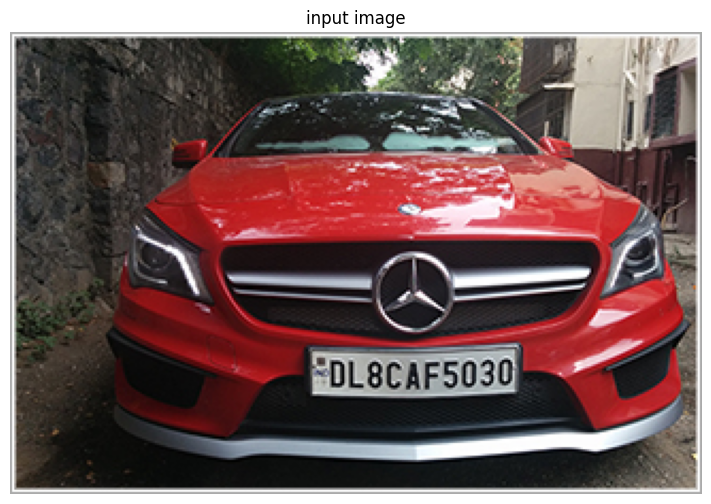

In [ ]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('/content/data/car.jpg')
display(img, 'input image')

In [ ]:
output_img, plate = detect_plate(img)

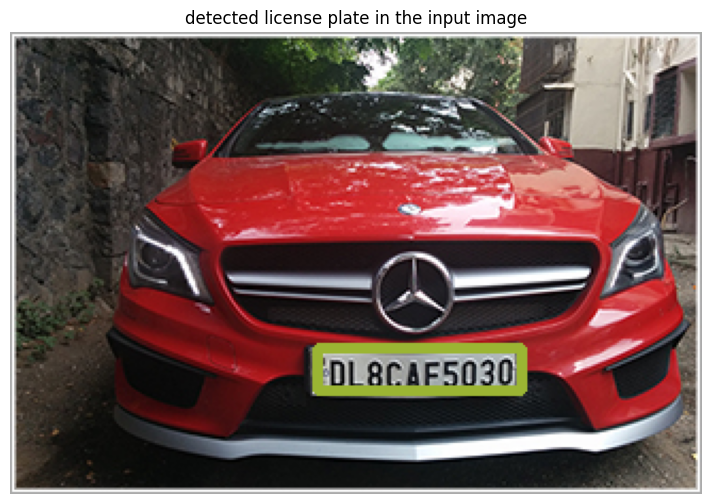

In [ ]:
display(output_img, 'detected license plate in the input image')

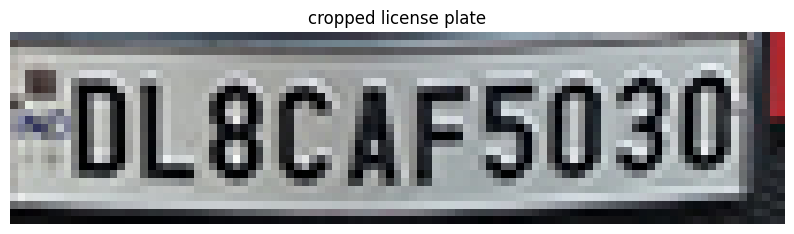

In [ ]:
display(plate, 'cropped license plate')

In [ ]:
def find_contours(dimensions, img):
  # Find contours
  contours , _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Get dimensions for filtering
  lower_width = dimensions[0]
  upper_width = dimensions[1]
  lower_height = dimensions[2]
  upper_height = dimensions[3]

  # Sort contours by area and take the top 30 (increased from 15)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]

  ii = cv2.imread('contour.jpg')
  x_cntr_list = []
  target_contours = []
  img_res = []
  for cntr in contours:
    # Get bounding box of the contour
    intX, intY, intW, intH = cv2.boundingRect(cntr)

    # Filter contours based on more refined dimensions (made more lenient)
    if intW > dimensions[0]*0.7 and intW < dimensions[1]*1.3 and intH > dimensions[2]*0.7 and intH < dimensions[3]*1.3 : # Adjusted multipliers
      x_cntr_list.append(intX)
      char_copy = np.zeros((44,24)) # Create a blank image for the character

      # Extract and resize the character
      char = img[intY:intY+intH, intX:intX+intW]
      char = cv2.resize(char, (20, 40))

      # Draw rectangle around the filtered contour
      cv2.rectangle(ii, (intX,intY), (intX+intW, intY+intH), (50,21,200),2)
      # Display the image with contours (for debugging)
      # plt.imshow(ii, cmap='gray')

      # Invert the character colors
      char = cv2.subtract(255, char)

      # Place the character in the center of the blank image
      char_copy[2:42, 2:22] = char
      char_copy[0:2, :] = 0
      char_copy[:, 0:2] = 0
      char_copy[42:44, :] = 0
      char_copy[:, 22:24] = 0

      img_res.append(char_copy)

  # Show the image with contours after the loop
  plt.imshow(ii, cmap='gray')
  plt.show()

  # Sort characters based on their x-coordinate
  indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
  img_res_copy = []
  for idx in indices:
    img_res_copy.append(img_res[idx])

  img_res = np.array(img_res_copy)

  return img_res

In [ ]:
def segment_characters(image):
    # Convert the input image to grayscale
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # Invert binary for CCA

    # Perform Connected Components Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_binary_lp, 8, cv2.CV_32S)

    char_list = []
    img_res = []
    # Iterate through detected components (excluding background)
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]

        # Filter components based on character properties
        # These thresholds may need tuning based on the dataset
        aspect_ratio = w / h if h > 0 else 0
        if 100 < area < 3000 and 0.2 < aspect_ratio < 1.0: # Example filtering criteria
            char_copy = np.zeros((44, 24), dtype=np.uint8) # Create a blank image for the character

            # Extract and resize the character
            char = img_binary_lp[y:y+h, x:x+w]
            char = cv2.resize(char, (20, 40), interpolation = cv2.INTER_AREA)

            # Place the character in the center of the blank image
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append((x, char_copy)) # Store x-coordinate for sorting

    # Sort characters based on their x-coordinate
    img_res.sort(key=lambda item: item[0])
    char_list = [item[1] for item in img_res]


    return np.array(char_list)

In [ ]:
char = segment_characters(plate)

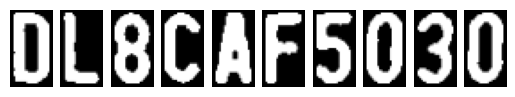

In [ ]:
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(char[i], cmap='gray')
  plt.axis('off')

In [ ]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1
)
path = '/content/data/data/data'

train_generator = train_datagen.flow_from_directory(
    path+'/train',
    target_size=(28, 28),
    batch_size=32,
    class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
    path+'/val',
    target_size=(28, 28),
    batch_size=32,
    class_mode='sparse')

Found 912 images belonging to 36 classes.
Found 264 images belonging to 36 classes.


In [ ]:
from sklearn.metrics import f1_score

class MicroF1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(MicroF1Score, self).__init__(name=name, **kwargs)
        # Initialize variables to accumulate counts for micro F1
        self.true_positives = self.add_weight(name='tp', initializer='zeros', dtype=tf.float32)
        self.false_positives = self.add_weight(name='fp', initializer='zeros', dtype=tf.float32)
        self.false_negatives = self.add_weight(name='fn', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=tf.int64) # Cast to int64 for comparison
        y_pred = tf.argmax(y_pred, axis=1) # Get predicted class labels

        # Calculate true positives, false positives, and false negatives for the current batch
        # Convert to one-hot encoding to easily calculate TP, FP, FN
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        y_pred_one_hot = tf.one_hot(y_pred, depth=tf.shape(y_true)[-1]) # Use depth from y_true

        tp = tf.reduce_sum(tf.cast(y_true_one_hot * y_pred_one_hot, dtype=tf.float32), axis=0)
        fp = tf.reduce_sum(tf.cast((1 - y_true_one_hot) * y_pred_one_hot, dtype=tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(y_true_one_hot * (1 - y_pred_one_hot), dtype=tf.float32), axis=0)

        # Accumulate counts
        self.true_positives.assign_add(tf.reduce_sum(tp))
        self.false_positives.assign_add(tf.reduce_sum(fp))
        self.false_negatives.assign_add(tf.reduce_sum(fn))


    def result(self):
        # Calculate micro F1 score from accumulated counts
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        micro_f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return micro_f1

    def reset_states(self):
        # Reset accumulated counts
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

    # Remove the _f1_score_func as we are now calculating micro F1 directly in result()

In [ ]:
from tensorflow.keras.layers import Input
K.clear_session()
model = Sequential()
model.add(Input(shape=(28, 28, 3)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001),metrics=[MicroF1Score()])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,672,868 (25.45 MB)

 Trainable params: 6,672,868 (25.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_f1 = logs.get('val_f1_score')
        if val_f1 is not None:
            if val_f1 > 0.99:
                self.model.stop_training = True



In [ ]:
import math
batch_size = 32
callbacks = [stop_training_callback()]
model.fit(
      train_generator,
      steps_per_epoch = math.ceil(train_generator.samples / batch_size),
      validation_data = validation_generator,
      validation_steps = math.ceil(validation_generator.samples / batch_size),
      epochs = 60, verbose=1, callbacks=callbacks)

Epoch 1/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - f1_score: 0.9680 - loss: 0.0876 - val_f1_score: 0.9830 - val_loss: 0.0634
Epoch 2/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - f1_score: 0.9682 - loss: 0.0989 - val_f1_score: 0.9658 - val_loss: 0.1368
Epoch 3/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - f1_score: 0.9581 - loss: 0.1675 - val_f1_score: 0.9702 - val_loss: 0.0974
Epoch 4/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - f1_score: 0.9688 - loss: 0.1417 - val_f1_score: 0.9787 - val_loss: 0.0527
Epoch 5/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - f1_score: 0.9608 - loss: 0.1092 - val_f1_score: 0.9828 - val_loss: 0.0994
Epoch 6/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1_score: 0.9708 - loss: 0.0704 - val_f1_score: 0.9831 - val_loss: 0.0562
Epoch 7/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1_score: 0.9641 - loss: 0.1089 - val_f1_score: 0.9597 - val_loss: 0.1100
Epoch 8/60
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1_score: 0.9738 - loss: 0.0829 - val_f1_score: 0.9742 - val_loss:

In [ ]:
def fix_dimension(img):
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results(char_list): # Added char_list parameter
  dic = {}
  characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  for i,c in enumerate(characters):
    dic[i] = c

  output = []

  # Handle cases where no characters are detected
  if len(char_list) == 0: # Changed char to char_list
      return "No characters detected"

  for i, ch in enumerate(char_list): # Changed char to char_list
    # Ensure the image is not empty before resizing
    if ch.shape[0] > 0 and ch.shape[1] > 0:
        img_ = cv2.resize(ch, (28,28), interpolation = cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        pred = model.predict(img)
        predicted_class_index = np.argmax(pred, axis=1)[0]
        character = dic[predicted_class_index]
        output.append(character)
    else:
        # Append a placeholder if a character is not properly segmented
        output.append("_")


  plate_number = ''.join(output)

  return plate_number

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Numbers in plate : 0L8CAF5030


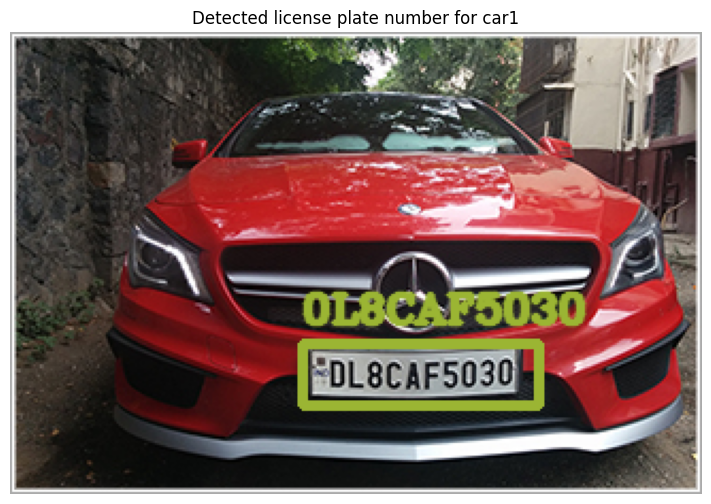

In [ ]:
img_car = cv2.imread('/content/data/car.jpg')
output_img_car, plate_car = detect_plate(img_car)
char_car = segment_characters(plate_car)
plate_number_car = show_results(char_car)
print('Numbers in plate :', plate_number_car)
output_img_car_with_text, _ = detect_plate(img_car, plate_number_car)
display(output_img_car_with_text, 'Detected license plate number for car1')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Numbers in plate : KA29Z999


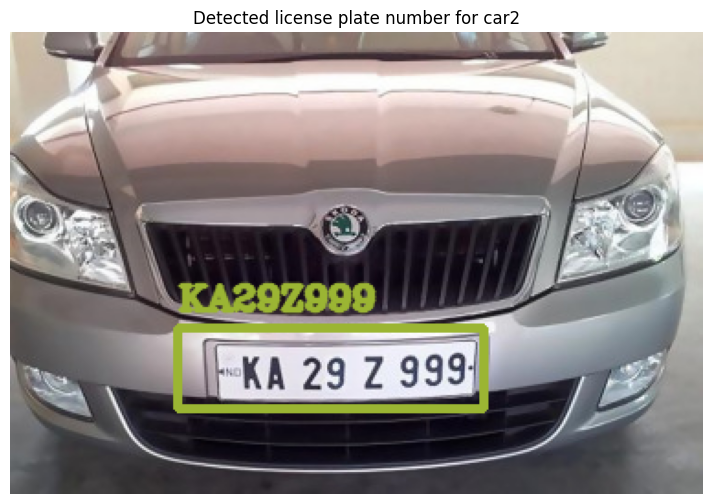

In [ ]:

img_original = cv2.imread('/content/data/3-s2.0-B9780323905923000070-f06-05-9780323905923.jpg')
output_img_original, plate_original = detect_plate(img_original)
char_original = segment_characters(plate_original)
plate_number_original = show_results(char_original)
print('Numbers in plate :', plate_number_original)
output_img_original_with_text, _ = detect_plate(img_original, plate_number_original)
display(output_img_original_with_text, 'Detected license plate number for car2')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Numbers in plate : MH20EE7602


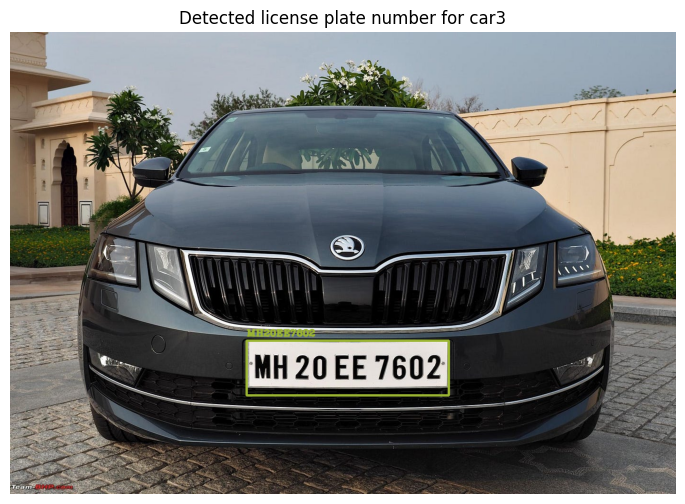

In [ ]:

img_original = cv2.imread('/content/data/1_qre-gAVNTuazaUPvNw2w-Q.jpg')
output_img_original, plate_original = detect_plate(img_original)
char_original = segment_characters(plate_original)
plate_number_original = show_results(char_original)
print('Numbers in plate :', plate_number_original)
output_img_original_with_text, _ = detect_plate(img_original, plate_number_original)
display(output_img_original_with_text, 'Detected license plate number for car3')

Numbers in plate : No characters detected


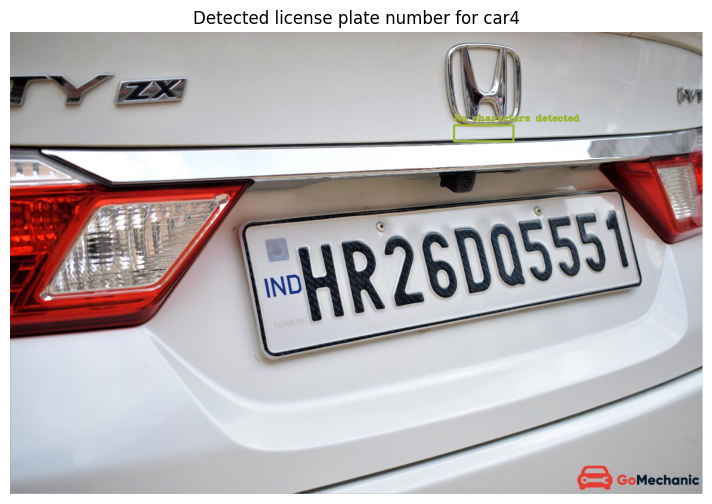

In [ ]:
img_original = cv2.imread('/content/data/typesofcarnumberplates-02-01.jpg')
output_img_original, plate_original = detect_plate(img_original)
char_original = segment_characters(plate_original)
plate_number_original = show_results(char_original)
print('Numbers in plate :', plate_number_original)
output_img_original_with_text, _ = detect_plate(img_original, plate_number_original)
display(output_img_original_with_text, 'Detected license plate number for car4')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Numbers in plate : HR26DK8337


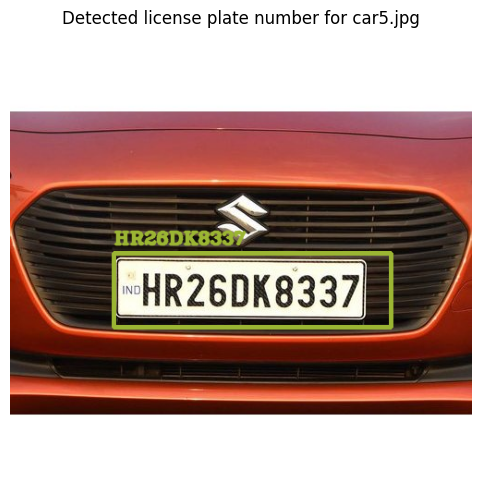

In [ ]:
img_original = cv2.imread('/content/data/car-number-plate.jpg')
output_img_original, plate_original = detect_plate(img_original)
char_original = segment_characters(plate_original)
plate_number_original = show_results(char_original)
print('Numbers in plate :', plate_number_original)
output_img_original_with_text, _ = detect_plate(img_original, plate_number_original)
display(output_img_original_with_text, 'Detected license plate number for car5.jpg')

An interesting observation. Since the model was able to predict '**D**' correctly in the fifth image, it suggests the model itself can recognize the character '**D**'. The issue with the first image is likely due to either:

Differences in the appearance of the character '**D**': The '**D**' in the first image might look different due to factors like lighting, angle, or slight distortions compared to the '**D**'s the model was trained on or the '**D**' in the fifth image.










The license plate was not detected in the fourth image. This means the issue lies in the initial detection step using the **Haar Cascade classifier (cv2.CascadeClassifier)**.

**Haar Cascades** are trained on specific patterns and might not be robust to variations in lighting, angle, size, or style of license plates. In this particular image, the angle or lighting conditions might be causing the classifier to fail.

To improve the detection for this image and potentially others, you could consider:

1. Training a more robust detection model: Instead of Haar Cascades, you could use more advanced object detection models like **YOLO** or **SSD** which are generally more accurate and robust.
2. Preprocessing the image: Applying image processing techniques like adjusting brightness, contrast, or applying filters before passing the image to the Haar Cascade could help.
3. Using a different **Haar Cascade file**: There might be other **pre - trained Haar Cascade classifiers** available that are better suited for the type of license plates in your images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Numbers in plate : 21BH2345AA


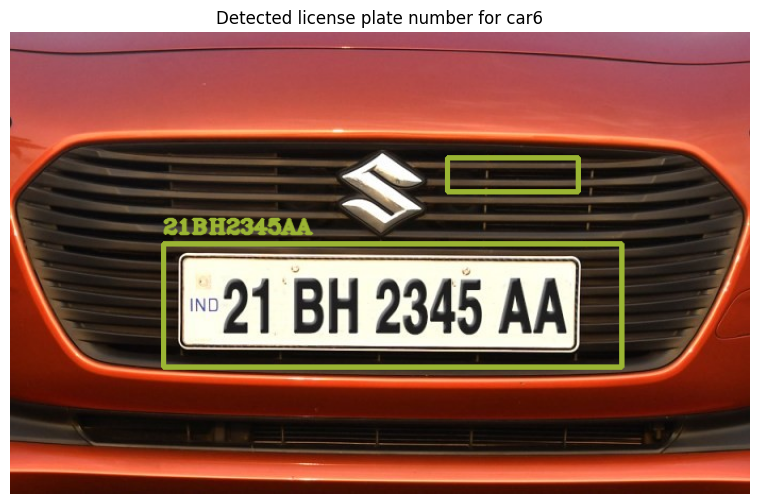

In [ ]:
img_original = cv2.imread('/content/data/BH-series-number-plate.jpg')
output_img_original, plate_original = detect_plate(img_original)
char_original = segment_characters(plate_original)
plate_number_original = show_results(char_original)
print('Numbers in plate :', plate_number_original)
output_img_original_with_text, _ = detect_plate(img_original, plate_number_original)
display(output_img_original_with_text, 'Detected license plate number for car6')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Numbers in plate : KA64N0099


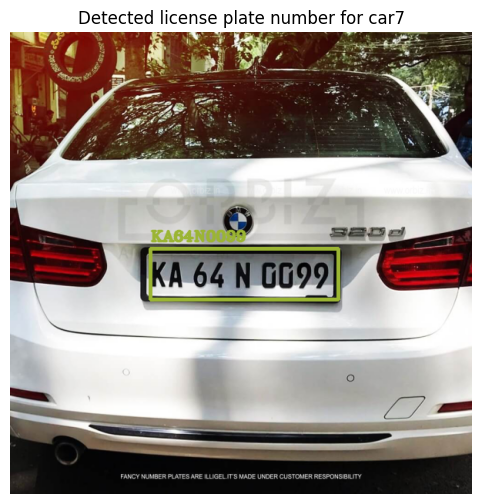

In [ ]:
img_original = cv2.imread('/content/data/customer-images-for-site2-1-600x600.png')
output_img_original, plate_original = detect_plate(img_original)
char_original = segment_characters(plate_original)
plate_number_original = show_results(char_original)
print('Numbers in plate :', plate_number_original)
output_img_original_with_text, _ = detect_plate(img_original, plate_number_original)
display(output_img_original_with_text, 'Detected license plate number for car7')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Numbers in plate : DL3C06758


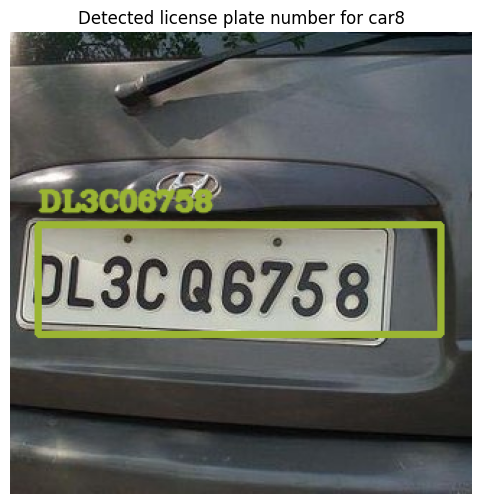

In [ ]:
img_original = cv2.imread('/content/data/Sample-results-of-the-identification-stage_Q320.jpg')
output_img_original, plate_original = detect_plate(img_original)
char_original = segment_characters(plate_original)
plate_number_original = show_results(char_original)
print('Numbers in plate :', plate_number_original)
output_img_original_with_text, _ = detect_plate(img_original, plate_number_original)
display(output_img_original_with_text, 'Detected license plate number for car8')